# **Лабораторная работа №6**
**Чаплин Виталий (гр.5130901/10202)**

# Упражнение 6.1

В данной главе утверждается, что analyze1 требует времени пропорционально
n^3, а analyze2 - пропорционально n^2. Убедимся в этом, запуская их с несколькими разными массивами и засекая время работы.
В блокнотах Jupyter можно использовать "волшебную команду" %timeit.

In [ ]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

--2024-04-15 11:32:24--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2024-04-15 11:32:25--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48574 (47K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.44K  --.-KB/s    in 0.04s   

2024-04-15 11:32:25 (1.21 MB/s) - ‘thinkdsp.py’ saved [48574/48574]



Создадим шумовой сигнал

In [ ]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

Создадим функцию, которая извлекает массив результатов из временного эксперимента, строит график и аппроксимирует результат прямой линией.

In [ ]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):
    plt.plot(ns, bests)
    decorate(**loglog)

    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)

    bests = [result.best for result in results]
    return bests

Рассмотрим результаты для analyze1

64
147 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
575 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
2.34 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
12.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
73.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
499 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
2.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.3664032332730773

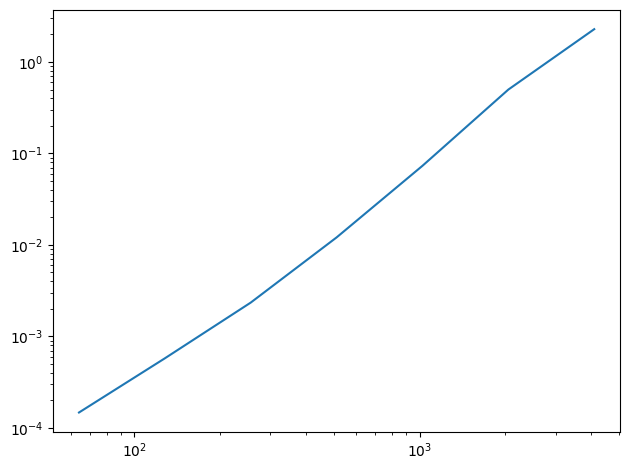

In [ ]:
ns = 2 ** np.arange(6, 13)
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

Можно заметить, что наклон получился близок не к 3, а к 2. Вероятно, это произошло из-за того, что в данном случае производительность np.linalg.solve близка к квадратичной

Рассмотрим результаты для analyze2


In [ ]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

64
58.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
336 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.32 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
5.46 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
25.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
96.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
424 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.1093817354483586

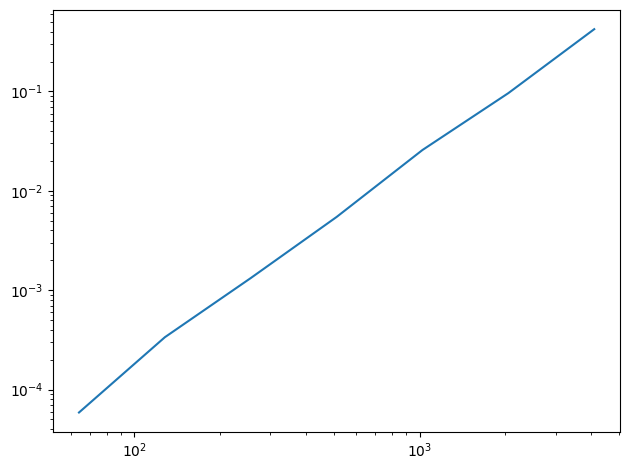

In [ ]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

В итоге получили почти прямую линию с наклоном, близким к 2, как и ожидалось.

Рассмотрим результаты для scipy.fftpack.dct

In [ ]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

64
4.27 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
128
4.64 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
5.32 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
6.23 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
8.28 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
2048
18.4 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
4096
23.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


0.4293027590100318

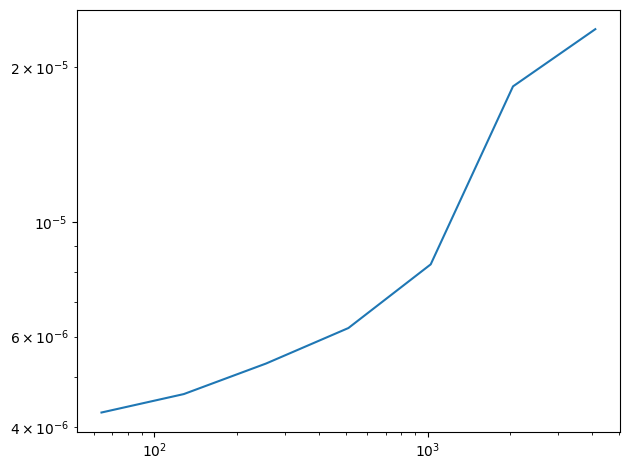

In [ ]:
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

По графику можно увидеть, что эта функция работает быстрее, время её работы пропорционально N * log(N).

Рассмотрим результаты для dct_iv

In [ ]:
def dct_iv(ys, freqs, ts):
  N = len(ys)
  ts = (0.5 + np.arange(N))/N
  fs = (0.5 + np.arange(N))/2
  args = np.outer(ts,fs)
  M = np.cos(PI2*args)
  amps = np.dot(M, ys) / 2
  return amps

64
67.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
367 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.89 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
5.69 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
27.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
97.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
410 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.0604310954303227

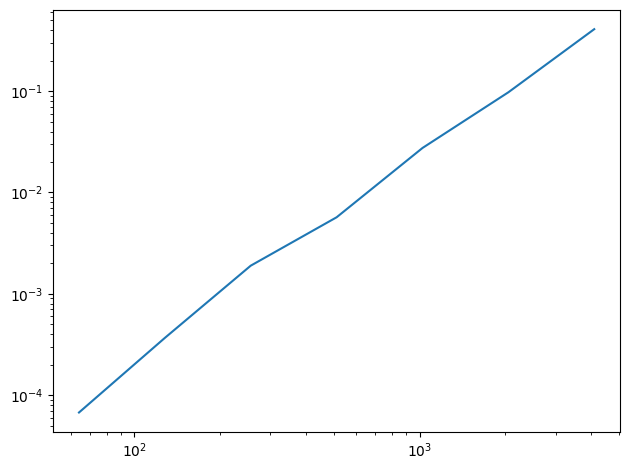

In [ ]:
bests4 = run_speed_test(ns, dct_iv)
plot_bests(ns, bests4)

В итоге получили почти прямую линию с наклоном, примерно близким к 2.

Поместим все кривые на один график.

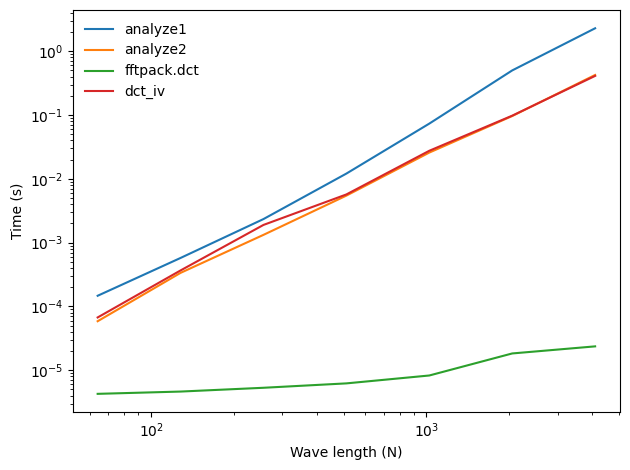

In [ ]:
plt.plot(ns, bests, label='analyze1')
plt.plot(ns, bests2, label='analyze2')
plt.plot(ns, bests3, label='fftpack.dct')
plt.plot(ns, bests4, label='dct_iv')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', **loglog)

# Упражнение 6.2

In [ ]:
if not os.path.exists('92002__jcveliz__violin-origional.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/92002__jcveliz__violin-origional.wav

--2024-04-15 12:41:15--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/92002__jcveliz__violin-origional.wav
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/92002__jcveliz__violin-origional.wav [following]
--2024-04-15 12:41:15--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/92002__jcveliz__violin-origional.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441044 (431K) [audio/wav]
Saving to: ‘92002__jcveliz__violin-origional.wav’

92002__jcveliz__vio 100%[===================>] 430.71K  --.-KB/s    in 0.1s    

2024-04-15 12:41:

Загрузим запись и послушаем, извлечем из неё сегмент

In [ ]:
from thinkdsp import read_wave

wave = read_wave('92002__jcveliz__violin-origional.wav')
wave.make_audio()

In [ ]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

Получим ДКП сигнала

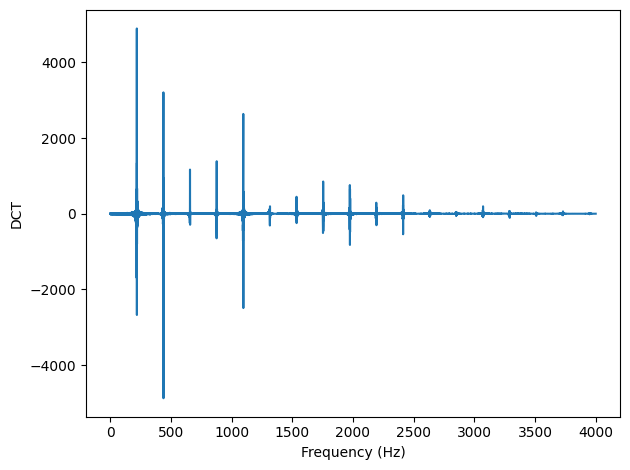

In [ ]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Создадим функцию compress, которая убирает из ДКП частоты со значениями ниже заданного tresh

In [ ]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1

    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

20397	22050	92.50340136054422


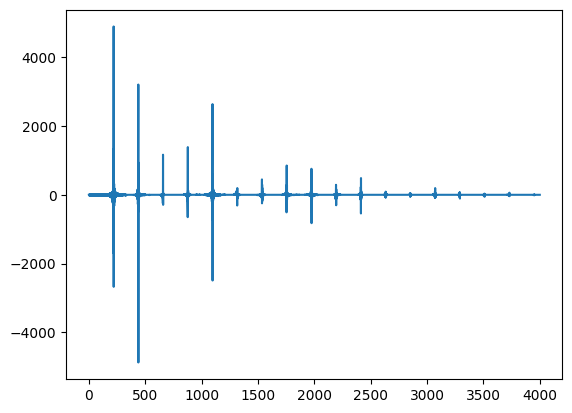

In [ ]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

In [ ]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Звук остался практически неизменным при сжатии в 92.5%

Создадим функцию, которая позволит получить спектрограмму ДКП

In [ ]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Теперь можно сжать все сегменты ДСП

In [ ]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.02)

980	1024	95.703125
982	1024	95.8984375
938	1024	91.6015625
962	1024	93.9453125
927	1024	90.52734375
916	1024	89.453125
904	1024	88.28125
846	1024	82.6171875
879	1024	85.83984375
899	1024	87.79296875
830	1024	81.0546875
680	1024	66.40625
620	1024	60.546875
556	1024	54.296875
505	1024	49.31640625
502	1024	49.0234375
512	1024	50.0
483	1024	47.16796875
491	1024	47.94921875
489	1024	47.75390625
476	1024	46.484375
440	1024	42.96875
468	1024	45.703125
485	1024	47.36328125
488	1024	47.65625
502	1024	49.0234375
519	1024	50.68359375
512	1024	50.0
483	1024	47.16796875
516	1024	50.390625
521	1024	50.87890625
512	1024	50.0
536	1024	52.34375
496	1024	48.4375
346	1024	33.7890625
459	1024	44.82421875
479	1024	46.77734375
483	1024	47.16796875
475	1024	46.38671875
491	1024	47.94921875
518	1024	50.5859375
498	1024	48.6328125
494	1024	48.2421875
501	1024	48.92578125
532	1024	51.953125
549	1024	53.61328125
533	1024	52.05078125
404	1024	39.453125
502	1024	49.0234375
535	1024	52.24609375
543	1024	53.02734375

Большинство сегментов удалось сжать на 40-60%

In [ ]:
wave2 = spectro.make_wave()
wave2.make_audio()

Попробуем увеличить процент сжатия для выявления шумов

In [ ]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

1021	1024	99.70703125
1022	1024	99.8046875
1024	1024	100.0
1021	1024	99.70703125
1018	1024	99.4140625
1019	1024	99.51171875
1021	1024	99.70703125
1013	1024	98.92578125
1012	1024	98.828125
1012	1024	98.828125
1013	1024	98.92578125
945	1024	92.28515625
926	1024	90.4296875
883	1024	86.23046875
890	1024	86.9140625
859	1024	83.88671875
824	1024	80.46875
822	1024	80.2734375
831	1024	81.15234375
807	1024	78.80859375
838	1024	81.8359375
774	1024	75.5859375
803	1024	78.41796875
817	1024	79.78515625
808	1024	78.90625
825	1024	80.56640625
821	1024	80.17578125
828	1024	80.859375
837	1024	81.73828125
832	1024	81.25
846	1024	82.6171875
819	1024	79.98046875
840	1024	82.03125
830	1024	81.0546875
734	1024	71.6796875
786	1024	76.7578125
786	1024	76.7578125
821	1024	80.17578125
808	1024	78.90625
841	1024	82.12890625
829	1024	80.95703125
836	1024	81.640625
833	1024	81.34765625
841	1024	82.12890625
830	1024	81.0546875
864	1024	84.375
853	1024	83.30078125
773	1024	75.48828125
829	1024	80.95703125
845	1024	8

In [ ]:
wave2 = spectro.make_wave()
wave2.make_audio()

При сжатии в 75-85% различимы шумы.

# Упражнение 6.3

In [ ]:
if not os.path.exists('105977__wcfl10__favorite-station.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/105977__wcfl10__favorite-station.wav

--2024-04-15 13:15:00--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/105977__wcfl10__favorite-station.wav
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/105977__wcfl10__favorite-station.wav [following]
--2024-04-15 13:15:00--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/105977__wcfl10__favorite-station.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247938 (242K) [audio/wav]
Saving to: ‘105977__wcfl10__favorite-station.wav’

105977__wcfl10__fav 100%[===================>] 242.13K  --.-KB/s    in 0.1s    

2024-04-15 13:15:

Загрузим запись и послушаем, извлечем из неё сегмент

In [ ]:
wave = read_wave('105977__wcfl10__favorite-station.wav')
wave.make_audio()

In [ ]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

Напишем функции для вывода амплитуды, углов и waveform заданного спектра

In [ ]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)',
             ylabel='Phase (radian)')

In [ ]:
def plot_three(spectrum, thresh=1):
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

Получим данные для оригинального сегмента

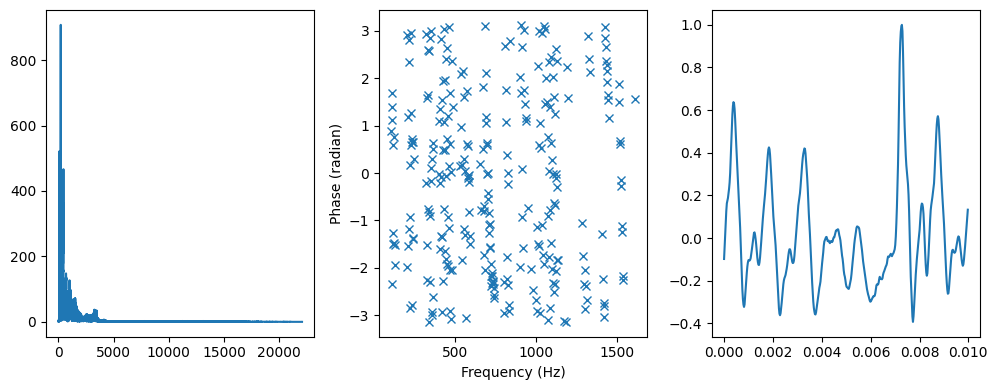

In [ ]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Создадим функцию zero_angle для обнуления всех углов сегмента

In [ ]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

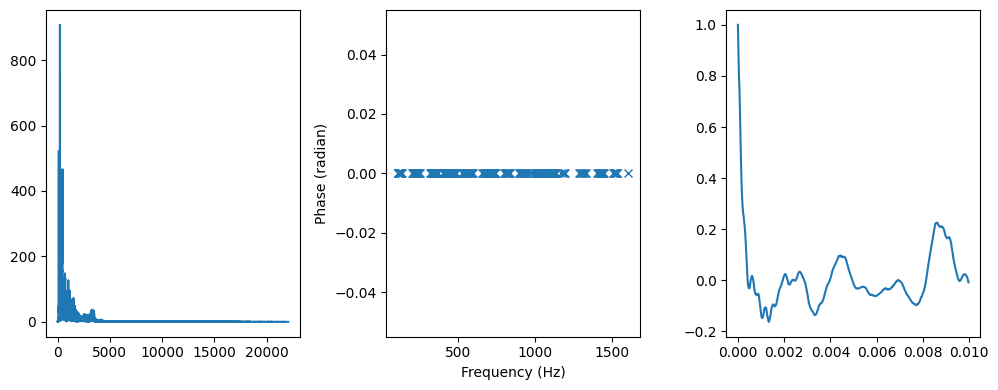

In [ ]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

После обнуления углов сегмент звучит намного тише, человеческий голос едва различим.

Теперь напишем функцию для поворота углов на 1 радиан

In [ ]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

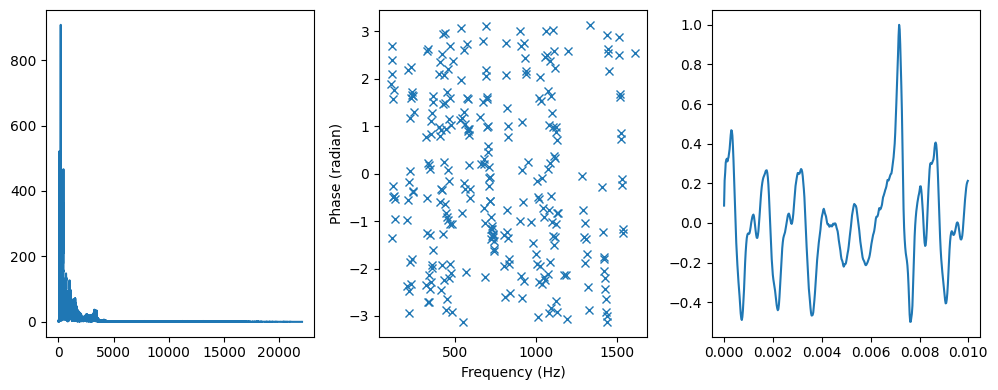

In [ ]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Сигнал кажется неизменным

Создадим функцию для рандомизации углов

In [ ]:
PI2 = np.pi * 2

def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

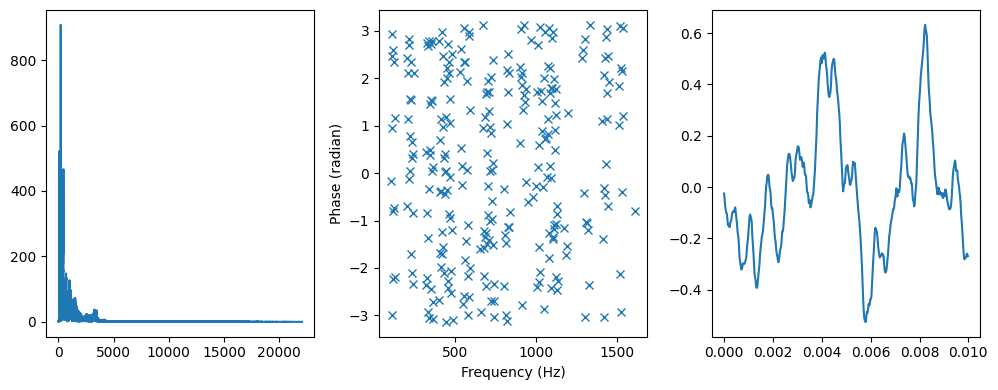

In [ ]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

К начальной записи добавилось эхо